# 무비렌즈 데이터를 가지고 사용자 협업 필터링을 구현해보기

surprise 모듈을 설치

In [33]:
conda install surprise

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: failed with initial frozen solve. Retrying with flexible solve.

PackagesNotFoundError: The following packages are not available from current channels:

  - surprise

Current channels:

  - https://repo.anaconda.com/pkgs/main/osx-64
  - https://repo.anaconda.com/pkgs/main/noarch
  - https://repo.anaconda.com/pkgs/r/osx-64
  - https://repo.anaconda.com/pkgs/r/noarch

To search for alternate channels that may provide the conda package you're
looking for, navigate to

    https://anaconda.org

and use the search bar at the top of the page.



Note: you may need to restart the kernel to use updated packages.


# 데이터 로딩 및 분석

In [56]:
from surprise import Dataset
from surprise import Reader

from collections import defaultdict
import numpy as np
import pandas as pd

In [57]:
movies = pd.read_csv("https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/movies.csv")
ratings = pd.read_csv("https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/ratings.csv")

In [58]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [59]:
ratings.head()
# timestamp는 유용한 정보 : 사용자의 취향은 시간에 따라 변하기 때문에 충분한 시간정보가 있으면 변화 추이? 최근 평점에 가중을 더할수도?

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [60]:
movie_ratings = pd.merge(movies, ratings, left_on='movieId', right_on='movieId')

In [61]:
movie_ratings.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,3.0,851866703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,9,4.0,938629179
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,13,5.0,1331380058
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.0,997938310
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,19,3.0,855190091


In [62]:
movies.shape

(9125, 3)

In [63]:
ratings.shape

(100004, 4)

In [64]:
movie_ratings.shape

(100004, 6)

# EDA 해보기

데이터 분석

*   영화별 평점수: min, max, median, mean
*   가장 평점이 많은 영화 10개는?
*   영화별 평점 평균: min, max, median, mean
*   가장 평점이 높은 영화 10개는? (100개 이상 평점이 있는 영화중) 왜냐하면 평점 개수가 너무 없으면 대중적으로 인기가 없을 수도 있으ㄱ니까?




In [65]:
movie_ratings["movieId"].nunique()

# moviesdpsms 9125개인데 69개 정도가 없다. rating에 없는 영화라고 할 수 있음

9066

In [66]:
movie_rating_summary = movie_ratings[["movieId", "rating"]].groupby(["movieId"]).agg(["count", "median", "mean"])

In [67]:
movie_rating_summary.head()

rating                 
         count median      mean
movieId                        
1          247    4.0  3.872470
2          107    3.0  3.401869
3           59    3.0  3.161017
4           13    3.0  2.384615
5           56    3.0  3.267857

In [68]:
movie_rating_summary.columns

# groupby를 한 다음 agg를 해서 컬럼 이름이 멀티인덱스 형태이다.

MultiIndex([('rating',  'count'),
            ('rating', 'median'),
            ('rating',   'mean')],
           )

In [69]:
movie_rating_summary.columns = ["count", "median", "mean"]

# 컬럼이름 바꾸기

In [70]:
movie_rating_summary.sort_values("count", ascending=False).head(10)

,count,median,mean
movieId,,,
356,341,4.0,4.054252
296,324,4.5,4.256173
318,311,5.0,4.487138
593,304,4.0,4.138158
260,291,4.5,4.221649
480,274,4.0,3.706204
2571,259,4.5,4.183398
1,247,4.0,3.872470
527,244,4.5,4.303279


In [71]:
movie_rating_summary.sort_values("mean", ascending=False).head(10)

# 평점 100개 이상인 영화에 대해서만 필터링을 하지 않았을 경우

,count,median,mean
movieId,,,
163949,1,5.0,5.0
71180,1,5.0,5.0
51471,1,5.0,5.0
52617,1,5.0,5.0
53887,1,5.0,5.0
54251,1,5.0,5.0
54328,1,5.0,5.0
55555,1,5.0,5.0
56869,1,5.0,5.0


In [72]:
# 평점 100개 이상인 영화에 대해서만 필터링

movie_rating_summary[movie_rating_summary["count"] > 100].sort_values("mean", ascending=False).head(10)

,count,median,mean
movieId,,,
858,200,5.00,4.487500
318,311,5.00,4.487138
1221,135,5.00,4.385185
50,201,4.50,4.370647
527,244,4.50,4.303279
1193,144,4.50,4.256944
608,224,4.50,4.256696
296,324,4.50,4.256173
2858,220,4.25,4.236364


/Users/KBS/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mean', ylabel='Density'>

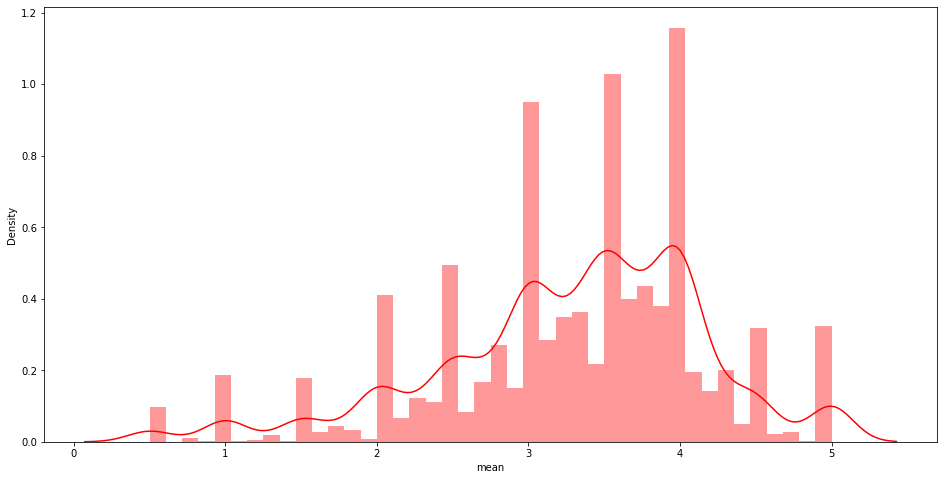

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
sns.distplot(a=movie_rating_summary['mean'], kde=True, color='r')

# "사람들이 대체적으로 평가를 후하게 주는 것을 알 수 있다 Why? 분포가 오른쪽으로(높게) 치우쳐져 있기 때문이다.")

/Users/KBS/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='count', ylabel='Density'>

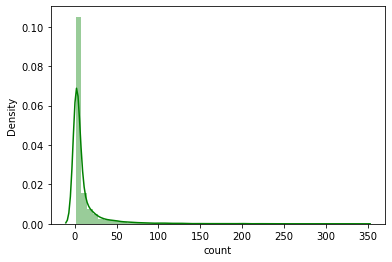

In [74]:
sns.distplot(a=movie_rating_summary['count'], color='g')


# #일부의 영화들이 평점을 많이 받은 것

In [75]:
movie_ratings["userId"].nunique()

# 671명의이 9천개 넘는 영화에 대해 10만개 이상 평점을 준 것이다.


671

In [76]:
user_rating_summary = movie_ratings[["userId", "rating"]].groupby(["userId"]).agg(["count", "median", "mean"])

# 유저별로 영화에 대해 몇 개의 평가를 줬는지?

In [77]:
user_rating_summary.head()

rating                 
        count median      mean
userId                        
1          20    2.5  2.550000
2          76    3.0  3.486842
3          51    3.5  3.568627
4         204    5.0  4.348039
5         100    4.0  3.910000

In [78]:
user_rating_summary.columns = ["count", "median", "mean"]

# 다시 컬럼명 바꾸기

In [79]:
user_rating_summary.sort_values("count", ascending=False).head(10)

,count,median,mean
userId,,,
547,2391,3.5,3.366792
564,1868,4.0,3.552463
624,1735,3.0,2.894236
15,1700,3.0,2.621765
73,1610,3.5,3.374224
452,1340,3.0,3.189179
468,1291,3.0,2.965918
380,1063,3.5,3.366416
311,1019,3.0,3.006379


In [80]:
user_rating_summary.sort_values("median", ascending=False).head(10)

,count,median,mean
userId,,,
230,94,5.0,4.473404
432,62,5.0,4.411290
622,31,5.0,4.725806
499,33,5.0,4.272727
145,38,5.0,4.500000
559,129,5.0,4.418605
473,76,5.0,4.315789
28,50,5.0,4.280000
556,25,5.0,4.400000


In [81]:
user_rating_summary.sort_values("median", ascending=True).head(10)

,count,median,mean
userId,,,
207,46,0.50,1.804348
581,49,0.50,1.459184
579,21,0.50,1.333333
609,140,1.00,1.985714
429,27,2.00,2.240741
315,55,2.00,2.454545
325,20,2.00,2.525000
35,20,2.25,2.400000
79,55,2.50,2.518182


/Users/KBS/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='mean', ylabel='Density'>

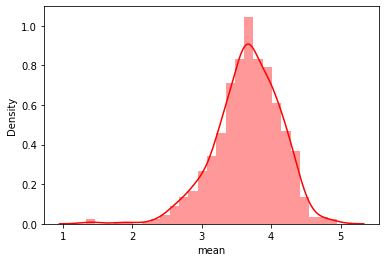

In [82]:
sns.distplot(a=user_rating_summary['mean'], kde=True, color='r')

/Users/KBS/opt/anaconda3/envs/pytorch/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='count', ylabel='Density'>

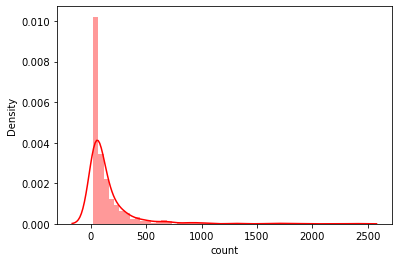

In [83]:
sns.distplot(a=user_rating_summary['count'], kde=True, color='r')

In [84]:
def getMovieName(movie_ratings, movieID):
    return movie_ratings[movie_ratings["movieId"] == movieID][["title", "genres"]].values[0]

# 무비레이팅과 무비 아이디를 주면 무비아이디를 기준으로 그 영화의 타이틀와 장르를 리턴

def getMovieID(movie_ratings, movieName):
    return movie_ratings[movie_ratings["title"] == movieName][["movieId", "genres"]].values[0]

# 무비레이팅과 무비 아이디를 주면 무비타이틀을 기준으로 그 영화의 타이틀와 장르를 리턴


## 영화 데이터를 surprise 모듈을 통해 로딩

In [85]:
conda install wget

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.13.0
  latest version: 4.14.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [86]:
!wget "https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/ratings.csv"

# 자체 로딩함수가 있따

--2022-09-06 15:09:27--  https://grepp-reco-test.s3.ap-northeast-2.amazonaws.com/movielens/ratings.csv
Resolving grepp-reco-test.s3.ap-northeast-2.amazonaws.com (grepp-reco-test.s3.ap-northeast-2.amazonaws.com)... 52.219.56.3
Connecting to grepp-reco-test.s3.ap-northeast-2.amazonaws.com (grepp-reco-test.s3.ap-northeast-2.amazonaws.com)|52.219.56.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2438266 (2.3M) [text/csv]
Saving to: 'ratings.csv.6'

ratings.csv.6       100%[===================>]   2.33M  10.1MB/s    in 0.2s    

2022-09-06 15:09:27 (10.1 MB/s) - 'ratings.csv.6' saved [2438266/2438266]



In [87]:
from surprise import Reader
from surprise import Dataset

reader = Reader(line_format='user item rating timestamp', sep=',', skip_lines=1)

data = Dataset.load_from_file("ratings.csv", reader=reader)

In [88]:
from surprise import KNNBasic
import heapq #사용자들을 뽑을때 사용
from collections import defaultdict #파이션 딕셔너리 문제 해결 기능?

In [89]:
trainSet = data.build_full_trainset() #모두다 트레이닝셋으로 로딩해라

#추천 엔진 평가와 관련이 있는건데, 일단 생략하고 모든 데이터를 훈련데이터로 쓰기로한다.

In [90]:
sim_options = {
    'name': 'cosine', #유사도 알고리즘 이름 정하기
    'user_based': True # false 설정 = 아이템기반
}

model = KNNBasic(sim_options=sim_options) # KNN 객체 만들기
model.fit(trainSet)
simsMatrix = model.compute_similarities() # 사용자들끼리 비교된 유사도 매트릭스


Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


In [91]:
testUser = '85' # 사용자 85번 대상
k = 10   #사용자 10명

# 주어진 사용자와 가장 흡사한 사용자 N을 찾는다
# 먼저 이를 Surprise 내부 ID로 변환
testUserInnerID = trainSet.to_inner_uid(testUser)
print(testUserInnerID)
# 이 사용자에 해당하는 레코드를 읽어온다
similarityRow = simsMatrix[testUserInnerID]


84


In [92]:
# 내림차순으로 정렬해야 유사도 높은 사람들끼리 
# users에 모든 사용자들을 일련번호와 유사도를 갖는 튜플의 형태로 저장
# 이 때 본인은 제외.
users = []
for innerID, score in enumerate(similarityRow):
    if (innerID != testUserInnerID):
        users.append( (innerID, score) )

In [93]:
# 이제 users 리트스에서 유사도 값을 기준으로 가장 큰 k개를 찾는다

# 값이 들어있는 리스트 리턴, 그 리스트에서 가장 큰 값 k개 찾는거,는 람다 함수
kNeighbors = heapq.nlargest(k, users, key=lambda t: t[1]) 

# users의 엘리먼트들은 innerID와 score로 두 개로 구성되어있는데

# 이런 element들을 t로 주어지면, t[1] = 두 번째 값, 즉 score 값을 기준으로 카장 큰 값을 k개 찾아서 리턴해줭

In [94]:
kNeighbors

[(10, 1.0),
 (11, 1.0),
 (13, 1.0),
 (24, 1.0),
 (36, 1.0),
 (44, 1.0),
 (45, 1.0),
 (51, 1.0),
 (53, 1.0),
 (61, 1.0)]

In [95]:
# 이제 유사 사용자들을 하나씩 보면서 그들이 평가한 아이템들별로 원 사용자와 유사 사용자간의 유사도를 가중치로 준 평점을 누적한다

# candidates에는 아이템별로 점수를 누적한다. 유사사용자(u')의 평점 * 사용자(u)와 유사 사용자(u')의 유사도
candidates = defaultdict(float)

# 이 K명의 최고 유사 사용자를 한명씩 루프를 돌면서 살펴본다
for similarUser in kNeighbors:
    # similarUser는 앞서 enumerate로 만든 그 포맷임 - (내부ID, 유사도값)
    innerID = similarUser[0]
    userSimilarityScore = similarUser[1]

    # innerID에 해당하는 사용자의 아이템과 평점 정보를 읽어온다.
    # theirRatings는 (아이템ID, 평점)의 리스트임
    theirRatings = trainSet.ur[innerID]
    # innerID가 평가한 모든 아이템 리스트를 하나씩 보면서 
    # 아이템ID별로 평점 정보를 합산하되 사용자와의 유사도값을 가중치로 준다
    for rating in theirRatings:
        candidates[rating[0]] += (rating[1]) * userSimilarityScore

In [96]:
# 사용자가 이미 평가한 아이템들을 제거할 사전을 만든다
watched = {}
for itemID, rating in trainSet.ur[testUserInnerID]:
    watched[itemID] = 1

In [97]:
# 앞서 candidates에서 합산된 스코어를 기준으로 내림차순으로 소팅한 후
# 사용자(u)가 아직 못본 아이템인 경우 추천한다
pos = 0
for itemID, ratingSum in sorted(candidates.items(), key=lambda k: k[1], reverse=True):
    if not itemID in watched:
        movieID = trainSet.to_raw_iid(itemID)
        print(movieID, getMovieName(movie_ratings, int(movieID)), ratingSum)
        pos += 1
        if (pos > 10):
            break

79132 ['Inception (2010)' 'Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX'] 16.5
1196 ['Star Wars: Episode V - The Empire Strikes Back (1980)'
 'Action|Adventure|Sci-Fi'] 12.0
26614 ['Bourne Identity, The (1988)' 'Action|Adventure|Drama|Mystery|Thriller'] 10.0
3996 ['Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)'
 'Action|Drama|Romance'] 10.0
58559 ['Dark Knight, The (2008)' 'Action|Crime|Drama|IMAX'] 10.0
1201 ['Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)'
 'Action|Adventure|Western'] 9.5
48516 ['Departed, The (2006)' 'Crime|Drama|Thriller'] 9.5
91529 ['Dark Knight Rises, The (2012)' 'Action|Adventure|Crime|IMAX'] 9.5
1270 ['Back to the Future (1985)' 'Adventure|Comedy|Sci-Fi'] 9.5
104841 ['Gravity (2013)' 'Action|Sci-Fi|IMAX'] 9.0
2959 ['Fight Club (1999)' 'Action|Crime|Drama|Thriller'] 9.0


In [98]:
# 위의 코드들을 총집합한 함수

def recommendForUser(userID):
    testUserInnerID = trainSet.to_inner_uid(userID)
    similarityRow = simsMatrix[testUserInnerID]

    users = []
    for innerID, score in enumerate(similarityRow):
        if (innerID != testUserInnerID):
            users.append( (innerID, score) )

    kNeighbors = heapq.nlargest(k, users, key=lambda t: t[1])

    candidates = defaultdict(float)
    for similarUser in kNeighbors:
        innerID = similarUser[0]
        userSimilarityScore = similarUser[1]
        theirRatings = trainSet.ur[innerID]
        for rating in theirRatings:
            candidates[rating[0]] += (rating[1]) * userSimilarityScore

    watched = {}
    for itemID, rating in trainSet.ur[testUserInnerID]:
        watched[itemID] = 1

    pos = 0
    for itemID, ratingSum in sorted(candidates.items(), key=lambda k: k[1], reverse=True):
        if not itemID in watched:
            movieID = trainSet.to_raw_iid(itemID)
            print(movieID, getMovieName(movie_ratings, int(movieID)), ratingSum)
            pos += 1
            if (pos > 10):
                break

In [100]:
recommendForUser('85')

79132 ['Inception (2010)' 'Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX'] 16.5
1196 ['Star Wars: Episode V - The Empire Strikes Back (1980)'
 'Action|Adventure|Sci-Fi'] 12.0
26614 ['Bourne Identity, The (1988)' 'Action|Adventure|Drama|Mystery|Thriller'] 10.0
3996 ['Crouching Tiger, Hidden Dragon (Wo hu cang long) (2000)'
 'Action|Drama|Romance'] 10.0
58559 ['Dark Knight, The (2008)' 'Action|Crime|Drama|IMAX'] 10.0
1201 ['Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966)'
 'Action|Adventure|Western'] 9.5
48516 ['Departed, The (2006)' 'Crime|Drama|Thriller'] 9.5
91529 ['Dark Knight Rises, The (2012)' 'Action|Adventure|Crime|IMAX'] 9.5
1270 ['Back to the Future (1985)' 'Adventure|Comedy|Sci-Fi'] 9.5
104841 ['Gravity (2013)' 'Action|Sci-Fi|IMAX'] 9.0
2959 ['Fight Club (1999)' 'Action|Crime|Drama|Thriller'] 9.0
